## Smart Detection of Fake Job Postings Using TF-IDF and Naive Bayes Classifier

                ## Binary Classification: 0 – Real Job, 1 – Fake Job

In [39]:
# Run once
!pip install pandas numpy nltk scikit-learn matplotlib seaborn wordcloud


## Import Libraries

In [40]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Download NLTK Data


In [41]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load DataSet

In [42]:

data = pd.read_csv(r"C:\Users\gunas\Downloads\fake_job_postings.csv\fake_job_postings.csv")

print("Shape:", data.shape)
data.head()


Shape: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## EDA

In [43]:
## Missing values
data.isnull().sum()


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

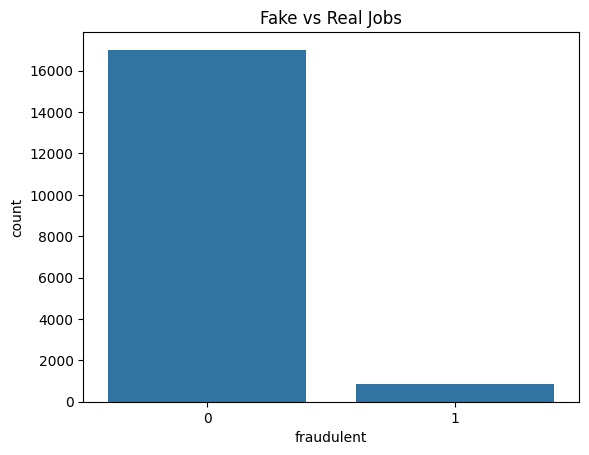

In [44]:
## target Distribution
sns.countplot(x='fraudulent', data=data)
plt.title("Fake vs Real Jobs")
plt.show()


In [45]:
## Class Percentage
data['fraudulent'].value_counts(normalize=True) * 100


fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64

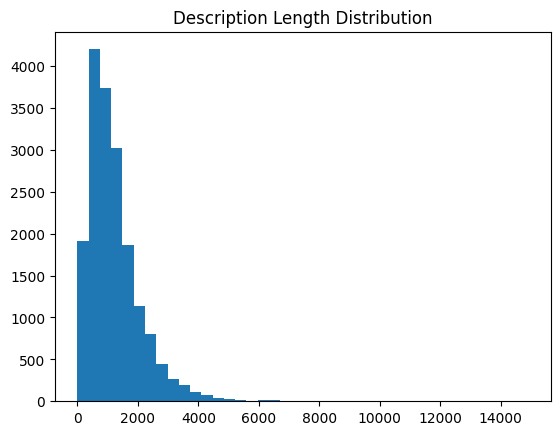

In [46]:
## Text Length Analysis
data['desc_len'] = data['description'].astype(str).apply(len)

plt.hist(data['desc_len'], bins=40)
plt.title("Description Length Distribution")
plt.show()


## WordCloud (Real Jobs)

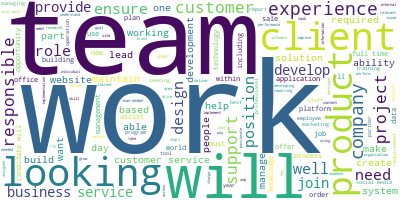

In [47]:
real = " ".join(data[data['fraudulent']==0]['description'].astype(str))

WordCloud(background_color="white").generate(real).to_image()


## WordCloud (Fake Jobs)

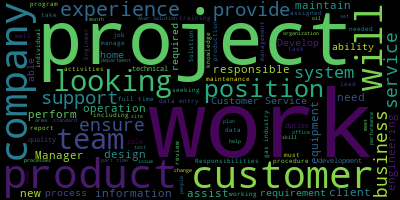

In [48]:
fake = " ".join(data[data['fraudulent']==1]['description'].astype(str))

WordCloud(background_color="black").generate(fake).to_image()


## Data Cleaning

In [51]:
## Handle Missing Values
data.fillna('', inplace=True)


In [52]:
## Merge Text Fields
data['text'] = data['title'] + " " + data['description']


In [53]:
## Select Required Columns
data = data[['text', 'fraudulent']]


## Text Preprocessing (Complete NLP Pipeline)

In [55]:

## Initialize NLP Tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


In [56]:
## Preprocessing Function
def preprocess_text(text):

    # 1. Lowercase
    text = text.lower()

    # 2. Remove numbers & symbols
    text = re.sub('[^a-zA-Z]', ' ', text)

    # 3. Tokenization
    tokens = word_tokenize(text)

    # 4. Stopword Removal
    tokens = [w for w in tokens if w not in stop_words]

    # 5. Lemmatization
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # 6. Stemming
    tokens = [stemmer.stem(w) for w in tokens]

    # 7. Join Back
    return " ".join(tokens)


In [57]:
## Apply Preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)
data.head()


,text,fraudulent,clean_text
0,"Marketing Intern Food52, a fast-growing, James...",0,market intern food fast grow jame beard award ...
1,Customer Service - Cloud Video Production Orga...,0,custom servic cloud video product organis focu...
2,Commissioning Machinery Assistant (CMA) Our cl...,0,commiss machineri assist cma client locat hous...
3,Account Executive - Washington DC THE COMPANY:...,0,account execut washington dc compani esri envi...
4,Bill Review Manager JOB TITLE: Itemization Rev...,0,bill review manag job titl item review manager...


## Feature Extraction (TF-IDF)

In [58]:
## Feature Extraction (TF-IDF)
tfidf = TfidfVectorizer(max_features=6000)

X = tfidf.fit_transform(data['clean_text']).toarray()
y = data['fraudulent']


## OVERCOME CLASS IMBALANCE(AVOID BIAS)

In [59]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X, y = smote.fit_resample(X, y)


## Train-Test Split

In [60]:
## Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Train Naive Bayes Model

In [61]:

model = MultinomialNB()

model.fit(X_train, y_train)


MultinomialNB()

##  Make Predictions

In [62]:

y_pred = model.predict(X_test)


In [63]:
## Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9196297384660593


## Classification Report

In [64]:
## Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3403
           1       0.92      0.92      0.92      3403

    accuracy                           0.92      6806
   macro avg       0.92      0.92      0.92      6806
weighted avg       0.92      0.92      0.92      6806



## Confusion Matrix

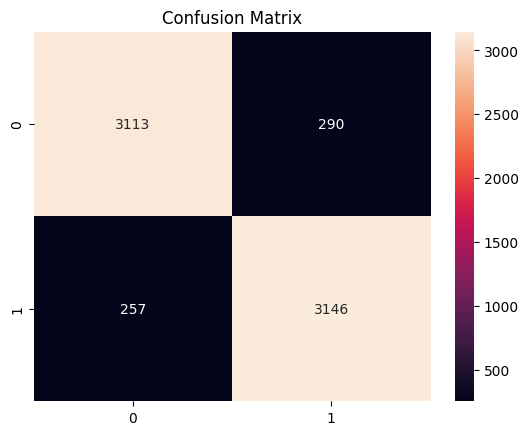

In [65]:

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
## Save Model

In [66]:

import pickle

pickle.dump(model, open("nb_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))


## real time prediction

In [67]:

def predict_job(text):

    text = preprocess_text(text)
    vec = tfidf.transform([text]).toarray()

    result = model.predict(vec)

    return "⚠️ Fake Job Posting" if result[0]==1 else "✅ Real Job Posting"




In [68]:
sample = "Work from home. Earn 5000 weekly. Send bank details."

print(predict_job(sample))


⚠️ Fake Job Posting


In [69]:
sample = """
ABC Technologies Pvt Ltd is hiring a Junior Data Analyst for our Bangalore office.

Job Responsibilities:
Collect, clean, and analyze business data.
Prepare reports and dashboards.
Support decision-making.

Requirements:
Bachelor’s degree, Python, Excel.

Apply through official website.
"""

print(predict_job(sample))


✅ Real Job Posting
